<a href="https://www.kaggle.com/code/rewa77/testing-with-ensemble-leanring?scriptVersionId=187245465" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import warnings
warnings.filterwarnings('ignore')

In [4]:
data = pd.read_csv('/kaggle/input/deepfake/BALANCED-DATA.csv')
data.head()

,chroma,rms,zcr,spectral_bandwidth,spectral_rolloff,spectral_centroid,MFCC1,MFCC2,MFCC3,MFCC4,...,MFCC12,MFCC13,MFCC14,MFCC15,MFCC16,MFCC17,MFCC18,MFCC19,MFCC20,Fake
0,0.248081,0.063475,0.078050,1605.131129,1490.395587,2862.0,-42.468452,122.740433,-54.283607,-3.310563,...,-5.747065,-29.186485,5.847217,-12.001443,-15.803621,-9.944556,5.828467,-5.746723,3.761436,1.0
1,0.395737,0.079791,0.186485,2631.894744,2454.641791,5862.0,104.196632,84.947922,-5.662404,-13.815593,...,-8.174358,-25.338980,-4.194548,-8.774382,-11.923344,-18.638382,6.972191,-7.080215,1.409794,1.0
2,0.364936,0.084366,0.160816,2218.847488,2053.061989,4286.0,120.004227,92.303528,-33.736412,-4.333049,...,-1.896176,-26.202858,-5.606716,-5.306311,-8.634595,-13.492945,-11.638796,-22.111092,0.811910,1.0
3,0.416679,0.091919,0.116916,2222.071645,1933.012772,4114.0,95.863052,101.077911,-29.916233,-16.413448,...,-6.020956,-18.767097,-6.694035,-22.182035,-13.110449,-15.595334,-6.542087,-12.968988,4.839046,1.0
4,0.220494,0.070675,0.156463,2425.796942,2293.921113,5183.0,77.415710,84.389847,-8.440239,0.957418,...,-8.322538,-12.404410,-0.156092,-10.027953,-4.420783,-13.091635,-4.134535,-14.849473,-3.254494,1.0


In [5]:
data.shape

(50894, 27)

In [6]:
data.isnull().sum() #no null values

chroma                0
rms                   0
zcr                   0
spectral_bandwidth    0
spectral_rolloff      0
spectral_centroid     0
MFCC1                 0
MFCC2                 0
MFCC3                 0
MFCC4                 0
MFCC5                 0
MFCC6                 0
MFCC7                 0
MFCC8                 0
MFCC9                 0
MFCC10                0
MFCC11                0
MFCC12                0
MFCC13                0
MFCC14                0
MFCC15                0
MFCC16                0
MFCC17                0
MFCC18                0
MFCC19                0
MFCC20                0
Fake                  0
dtype: int64

In [7]:
data.duplicated().sum()

1996

In [8]:
data.drop_duplicates(inplace=True)
data.reset_index(drop=True, inplace=True)

In [9]:
X = data.drop(columns = ['Fake'])
y = data['Fake']

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size =.2, random_state = 0)

# Ensemble Learning (XGBOOST and LightGBM)

In [11]:
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


xgb_clf = XGBClassifier(random_state=0)
lgbm_clf = LGBMClassifier(random_state=0)


voting_clf = VotingClassifier(estimators=[('xgb', xgb_clf), ('lgbm', lgbm_clf)], voting='soft')
voting_clf.fit(X_train, y_train)


y_train_pred = voting_clf.predict(X_train)
y_test_pred = voting_clf.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Voting Classifier Train Accuracy:", train_accuracy)
print("Voting Classifier Test Accuracy:", test_accuracy)

[LightGBM] [Info] Number of positive: 31319, number of negative: 7799
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012819 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 39118, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.800629 -> initscore=1.390229
[LightGBM] [Info] Start training from score 1.390229
Voting Classifier Train Accuracy: 0.9687867477887417
Voting Classifier Test Accuracy: 0.9209611451942741


In [12]:
from sklearn.model_selection import GridSearchCV


param_grid_xgb = {
    'learning_rate': [0.1, 0.01],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300]
}

param_grid_lgbm = {
    'learning_rate': [0.1, 0.01],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300]
}

# grid search for XGBoost
grid_search_xgb = GridSearchCV(estimator=xgb_clf, param_grid=param_grid_xgb, scoring='accuracy', cv=5)
grid_search_xgb.fit(X_train, y_train)

# grid search for LightGBM
grid_search_lgbm = GridSearchCV(estimator=lgbm_clf, param_grid=param_grid_lgbm, scoring='accuracy', cv=5)
grid_search_lgbm.fit(X_train, y_train)

# Get best estimators
best_xgb_clf = grid_search_xgb.best_estimator_
best_lgbm_clf = grid_search_lgbm.best_estimator_

voting_clf_tuned = VotingClassifier(estimators=[('xgb', best_xgb_clf), ('lgbm', best_lgbm_clf)], voting='soft')
voting_clf_tuned.fit(X_train, y_train)

train_accuracy_tuned = accuracy_score(y_train, voting_clf_tuned.predict(X_train))
test_accuracy_tuned = accuracy_score(y_test, voting_clf_tuned.predict(X_test))
print("Tuned Voting Classifier Train Accuracy:", train_accuracy_tuned)
print("Tuned Voting Classifier Test Accuracy:", test_accuracy_tuned)

[LightGBM] [Info] Number of positive: 25055, number of negative: 6239
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006988 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 31294, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.800633 -> initscore=1.390253
[LightGBM] [Info] Start training from score 1.390253
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


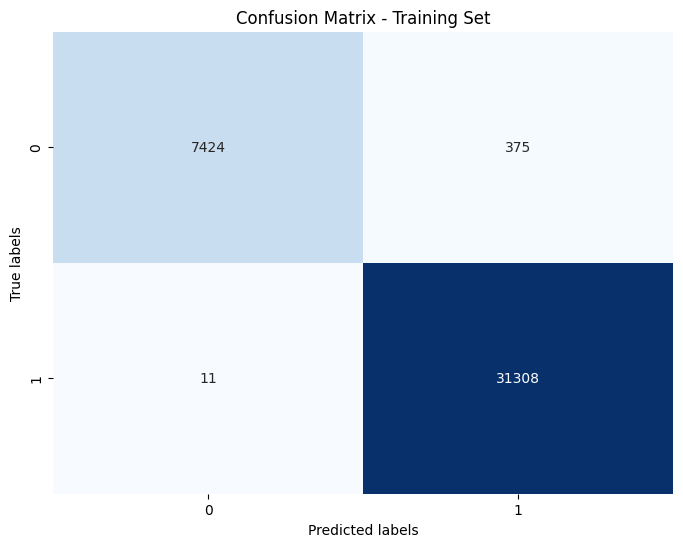

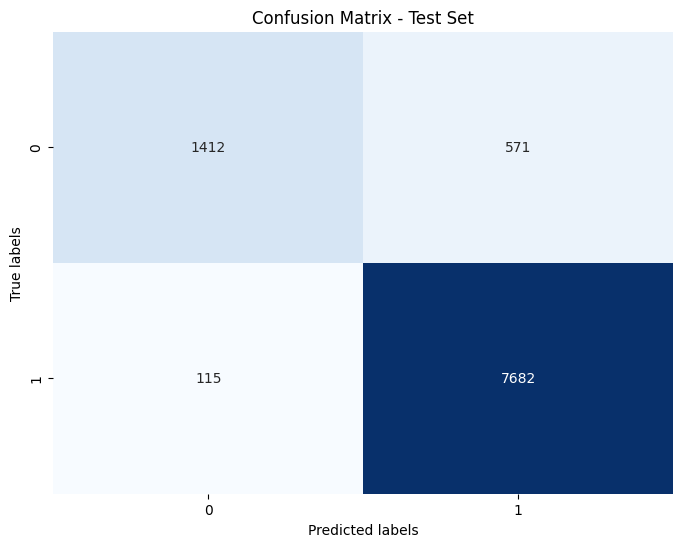

Classification Report - Training Set:
              precision    recall  f1-score   support

         0.0       1.00      0.95      0.97      7799
         1.0       0.99      1.00      0.99     31319

    accuracy                           0.99     39118
   macro avg       0.99      0.98      0.98     39118
weighted avg       0.99      0.99      0.99     39118

Classification Report - Test Set:
              precision    recall  f1-score   support

         0.0       0.92      0.71      0.80      1983
         1.0       0.93      0.99      0.96      7797

    accuracy                           0.93      9780
   macro avg       0.93      0.85      0.88      9780
weighted avg       0.93      0.93      0.93      9780



In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Predictions
y_pred_train = voting_clf_tuned.predict(X_train)
y_pred_test = voting_clf_tuned.predict(X_test)

# Confusion matrix for training set
plt.figure(figsize=(8, 6))
cm_train = confusion_matrix(y_train, y_pred_train)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - Training Set')
plt.show()

# Confusion matrix for test set
plt.figure(figsize=(8, 6))
cm_test = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - Test Set')
plt.show()

# Classification report
print("Classification Report - Training Set:")
print(classification_report(y_train, y_pred_train))

print("Classification Report - Test Set:")
print(classification_report(y_test, y_pred_test))

In [26]:
import joblib

joblib.dump(voting_clf_tuned, 'voting_clf_tuned.pkl')

['voting_clf_tuned.pkl']

# Test with Arabic Real

In [22]:
AR = '/kaggle/input/deepfake/mariamAR.csv'
df = pd.read_csv(AR)

In [23]:
df.isnull().sum()

chroma                 0
rms                    0
zcr                    0
spectral_bandwidth     0
spectral_rolloff       0
spectral_centroid      0
MFCC1                  0
MFCC2                  0
MFCC3                  0
MFCC4                  0
MFCC5                  0
MFCC6                  0
MFCC7                  0
MFCC8                  0
MFCC9                  0
MFCC10                 0
MFCC11                 0
MFCC12                 0
MFCC13                 0
MFCC14                 0
MFCC15                 0
MFCC16                 0
MFCC17                 0
MFCC18                 0
MFCC19                 0
MFCC20                 0
Fake                  60
dtype: int64

In [24]:
df.duplicated().sum()

0

In [31]:
df.head()

,chroma,rms,zcr,spectral_bandwidth,spectral_rolloff,spectral_centroid,MFCC1,MFCC2,MFCC3,MFCC4,...,MFCC12,MFCC13,MFCC14,MFCC15,MFCC16,MFCC17,MFCC18,MFCC19,MFCC20,Fake
0,0.772888,0.003094,0.080227,1560.615813,2183.621774,4126.0,-151.889023,87.888809,-52.149704,10.814874,...,7.937801,0.499509,4.665973,-11.481020,-12.577242,-3.431258,-9.902018,1.827203,-1.775650,NaN
1,0.265957,0.121910,0.167347,2382.301380,2879.292571,5861.0,84.690277,84.450485,-19.361971,25.945988,...,-24.691769,-3.246694,-2.871174,-6.302266,-16.440338,-8.488890,2.706564,-20.504387,7.032813,NaN
2,0.380243,0.173901,0.109524,1055.082086,1173.863443,1632.0,124.897446,190.457016,-89.030273,-4.139394,...,-21.383026,-8.677707,-10.398066,-3.069235,-21.244932,-10.741703,-8.519435,-16.043678,-2.432373,NaN
3,0.274754,0.156338,0.042630,1376.585715,1327.286694,3041.0,61.871552,160.891556,-70.828682,36.208519,...,-6.458497,-3.695046,-4.293035,-5.847181,-22.136251,-0.022388,-11.718180,-12.767897,-8.421888,NaN
4,0.405097,0.111090,0.041224,1352.371069,1214.733590,2812.0,27.303200,164.720947,-49.673412,36.680462,...,5.820308,-7.149957,-4.909221,-2.446558,-18.412640,1.849657,-14.091702,-8.390057,-4.748271,NaN


In [35]:
df['Fake'] = df['Fake'].fillna(0).astype(int)

In [36]:
df.head()

,chroma,rms,zcr,spectral_bandwidth,spectral_rolloff,spectral_centroid,MFCC1,MFCC2,MFCC3,MFCC4,...,MFCC12,MFCC13,MFCC14,MFCC15,MFCC16,MFCC17,MFCC18,MFCC19,MFCC20,Fake
0,0.772888,0.003094,0.080227,1560.615813,2183.621774,4126.0,-151.889023,87.888809,-52.149704,10.814874,...,7.937801,0.499509,4.665973,-11.481020,-12.577242,-3.431258,-9.902018,1.827203,-1.775650,0
1,0.265957,0.121910,0.167347,2382.301380,2879.292571,5861.0,84.690277,84.450485,-19.361971,25.945988,...,-24.691769,-3.246694,-2.871174,-6.302266,-16.440338,-8.488890,2.706564,-20.504387,7.032813,0
2,0.380243,0.173901,0.109524,1055.082086,1173.863443,1632.0,124.897446,190.457016,-89.030273,-4.139394,...,-21.383026,-8.677707,-10.398066,-3.069235,-21.244932,-10.741703,-8.519435,-16.043678,-2.432373,0
3,0.274754,0.156338,0.042630,1376.585715,1327.286694,3041.0,61.871552,160.891556,-70.828682,36.208519,...,-6.458497,-3.695046,-4.293035,-5.847181,-22.136251,-0.022388,-11.718180,-12.767897,-8.421888,0
4,0.405097,0.111090,0.041224,1352.371069,1214.733590,2812.0,27.303200,164.720947,-49.673412,36.680462,...,5.820308,-7.149957,-4.909221,-2.446558,-18.412640,1.849657,-14.091702,-8.390057,-4.748271,0


In [43]:
X_new = df.drop('Fake', axis=1)
y_new = df['Fake']

In [45]:
voting_clf_tuned = joblib.load('voting_clf_tuned.pkl')

In [46]:
y_pred_new = voting_clf_tuned.predict(X_new)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [48]:
df['predictions'] = y_pred_new
df.to_csv('test_predictions.csv', index=False)

print("Predictions:")
print(y_pred_new)


Predictions:
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [49]:
from sklearn.metrics import accuracy_score
if 'Fake' in df.columns:
    new_accuracy = accuracy_score(y_new, y_pred_new)
    print("New Dataset Accuracy:", new_accuracy)

New Dataset Accuracy: 0.9333333333333333


# Test with Real English

In [105]:
ENG = '/kaggle/input/deepfake/englishAudio.csv'
dff = pd.read_csv(ENG)

In [106]:
dff.isnull().sum()

chroma                 0
rms                    0
zcr                    0
spectral_bandwidth     0
spectral_rolloff       0
spectral_centroid      0
MFCC1                  0
MFCC2                  0
MFCC3                  0
MFCC4                  0
MFCC5                  0
MFCC6                  0
MFCC7                  0
MFCC8                  0
MFCC9                  0
MFCC10                 0
MFCC11                 0
MFCC12                 0
MFCC13                 0
MFCC14                 0
MFCC15                 0
MFCC16                 0
MFCC17                 0
MFCC18                 0
MFCC19                 0
MFCC20                 0
Fake                  60
dtype: int64

In [107]:
dff.duplicated().sum()

0

In [108]:
dff['Fake'] = dff['Fake'].fillna(0).astype(int)

In [109]:
dff.head()

,chroma,rms,zcr,spectral_bandwidth,spectral_rolloff,spectral_centroid,MFCC1,MFCC2,MFCC3,MFCC4,...,MFCC12,MFCC13,MFCC14,MFCC15,MFCC16,MFCC17,MFCC18,MFCC19,MFCC20,Fake
0,0.567088,0.002166,0.108662,1853.806714,2314.550911,4552.0,-262.920166,79.304199,-24.856411,27.353485,...,-1.157710,1.715569,-13.855444,-19.762148,-4.551015,5.583957,-2.344879,-5.543976,1.127403,0
1,0.684528,0.007785,0.168390,1595.108767,2192.728713,4041.0,-149.187332,107.773087,-68.071465,24.089851,...,-6.594520,5.877829,-8.087189,-16.773746,-9.576418,-3.515457,-3.983604,-4.188931,-0.573160,0
2,0.506163,0.089286,0.088073,1085.749141,1150.725247,1627.0,14.417723,189.095947,-69.567741,-5.289456,...,-28.662691,8.810030,-26.667570,-17.285877,-15.137770,-3.653783,0.395765,-19.089046,-1.362987,0
3,0.309374,0.105775,0.121859,2205.571805,2062.657660,5600.0,74.694717,117.833588,-27.431927,-1.350338,...,-20.415270,-2.385910,-28.192802,-19.375721,-8.282899,-6.643238,4.051905,-25.564356,12.138614,0
4,0.301881,0.081913,0.107982,1032.318724,891.829655,1410.0,-4.926766,204.526001,-42.180290,13.251980,...,-22.164982,2.863915,-21.924595,-16.165167,-15.832092,-2.988161,-2.449883,-16.281391,-2.674632,0


In [110]:
X_new2 = dff.drop('Fake', axis=1)
y_new2 = dff['Fake']

In [111]:
voting_clf_tuned = joblib.load('voting_clf_tuned.pkl')

In [112]:
y_pred_new2 = voting_clf_tuned.predict(X_new2)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [113]:
df['predictions'] = y_pred_new2
df.to_csv('test_predictions.csv', index=False)

print("Predictions:")
print(y_pred_new2)

Predictions:
[1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1.
 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [115]:
from sklearn.metrics import accuracy_score

y_true = y_new2
accuracy = accuracy_score(y_true, y_pred_new2)

# Print accuracy
print("Accuracy:", accuracy)

Accuracy: 0.23333333333333334


The RVC model can not differenate if the audio is real or fake with different language than the langauge it is trained upon. 

# Testing with english language for someone, the model has seen before

In [91]:
test = '/kaggle/input/deepfake/mariam_to_aboENG.csv'
test1 = pd.read_csv(test)

In [92]:
test1.isnull().sum()

chroma                 0
rms                    0
zcr                    0
spectral_bandwidth     0
spectral_rolloff       0
spectral_centroid      0
MFCC1                  0
MFCC2                  0
MFCC3                  0
MFCC4                  0
MFCC5                  0
MFCC6                  0
MFCC7                  0
MFCC8                  0
MFCC9                  0
MFCC10                 0
MFCC11                 0
MFCC12                 0
MFCC13                 0
MFCC14                 0
MFCC15                 0
MFCC16                 0
MFCC17                 0
MFCC18                 0
MFCC19                 0
MFCC20                 0
Fake                  60
dtype: int64

In [93]:
test1['Fake'] = test1['Fake'].fillna(1).astype(int)

In [94]:
test1.head()

,chroma,rms,zcr,spectral_bandwidth,spectral_rolloff,spectral_centroid,MFCC1,MFCC2,MFCC3,MFCC4,...,MFCC12,MFCC13,MFCC14,MFCC15,MFCC16,MFCC17,MFCC18,MFCC19,MFCC20,Fake
0,0.536105,0.002652,0.071791,2690.424517,3265.190807,6757.0,-254.053009,48.700317,-35.132408,-9.059432,...,-4.166384,-8.072926,6.130187,0.492148,7.898188,-5.018806,3.127909,-6.078751,-7.123068,1
1,0.589432,0.019862,0.130385,2157.182263,3047.794021,5332.0,-128.249313,43.570038,-73.262054,1.642691,...,-6.681610,-9.502752,11.976414,-2.875933,5.657652,-11.781189,-1.826438,-8.358059,-6.147973,1
2,0.423755,0.090024,0.103492,1347.278228,1217.436305,2424.0,81.926132,179.092468,-46.461559,18.794455,...,4.734848,-8.336886,-13.116900,-14.629948,3.002966,-22.022379,-1.463662,-3.524449,-11.141456,1
3,0.538172,0.120477,0.146803,2963.163926,3391.219094,7127.0,180.115829,61.749435,10.324575,9.511341,...,13.460370,-19.558533,-12.710642,-15.887700,4.680464,-10.777628,2.017505,-5.548545,-3.389791,1
4,0.469985,0.108488,0.121542,1727.429195,1263.465379,2412.0,99.913879,155.194260,-13.224529,13.242926,...,6.419889,-8.759111,-7.968075,-21.191677,2.098063,-21.009146,-6.257855,-6.315542,-2.306768,1


In [95]:
test1.duplicated().sum()

0

In [96]:
X_new3 = test1.drop('Fake', axis=1)
y_new3 = test1['Fake']

In [79]:
voting_clf_tuned = joblib.load('voting_clf_tuned.pkl')

In [98]:
y_pred_new3 = voting_clf_tuned.predict(X_new3)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [99]:
df['predictions'] = y_pred_new3
df.to_csv('test_predictions.csv', index=False)

print("Predictions:")
print(y_pred_new3)

Predictions:
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [103]:
from sklearn.metrics import accuracy_score

y_true = y_new3
accuracy = accuracy_score(y_true, y_pred_new3)

# Print accuracy
print("Accuracy:", accuracy)

Accuracy: 1.0


The model correctly predicted if the person is fake or not WITH DIFFERENT LANGUAGE THAN IT HAS TRAINED UPON.

# Test with new person with same language it is trained upon

In [116]:
test2 = '/kaggle/input/deepfake/mariam_to_margotAR.csv'
test2 = pd.read_csv(test2)

In [117]:
test2['Fake'] = test2['Fake'].fillna(1).astype(int)

In [118]:
X_new4 = test2.drop('Fake', axis=1)
y_new4 = test2['Fake']

In [119]:
voting_clf_tuned = joblib.load('voting_clf_tuned.pkl')

In [120]:
y_pred_new4 = voting_clf_tuned.predict(X_new4)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [121]:
df['predictions'] = y_pred_new4
df.to_csv('test_predictions.csv', index=False)

print("Predictions:")
print(y_pred_new4)

Predictions:
[1. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.
 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0.
 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0.]


In [124]:
from sklearn.metrics import accuracy_score

y_true = y_new4
accuracy = accuracy_score(y_true, y_pred_new4)

# Print accuracy
print("Accuracy:", accuracy)

Accuracy: 0.6


# Test with someone form the dataset with same language 

In [125]:
test3 = '/kaggle/input/deepfake/mariam_to_nedalAR.csv'
test3 = pd.read_csv(test3)

In [126]:
test3['Fake'] = test3['Fake'].fillna(1).astype(int)

In [127]:
X_new5 = test3.drop('Fake', axis=1)
y_new5 = test3['Fake']

In [128]:
voting_clf_tuned = joblib.load('voting_clf_tuned.pkl')

In [131]:
y_pred_new5 = voting_clf_tuned.predict(X_new5)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [132]:
df['predictions'] = y_pred_new5
df.to_csv('test_predictions.csv', index=False)

print("Predictions:")
print(y_pred_new4)

Predictions:
[1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0.]


In [133]:
from sklearn.metrics import accuracy_score

y_true = y_new5
accuracy = accuracy_score(y_true, y_pred_new5)

# Print accuracy
print("Accuracy:", accuracy)

Accuracy: 0.8666666666666667
